In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
plt.rcParams['font.family']='SimHei' #顯示中文

# 資料集載入以及簡略分析

In [2]:
train = pd.read_csv('input/train.csv', encoding = "utf-8", dtype = {'type': np.int32})
test = pd.read_csv('input/test.csv', encoding = "utf-8")

In [3]:
submission = pd.read_csv('input/submission.csv', encoding = "utf-8", dtype = {'type': np.int32})

## 用head大概了解各筆資料的樣子

In [4]:
train.head(3)

,id,花萼長度,花萼寬度,花瓣長度,花瓣寬度,屬種,type
0,1,5.4,3.7,1.5,0.2,Iris-setosa,1
1,2,4.8,3.4,1.6,0.2,Iris-setosa,1
2,3,4.8,3.0,1.4,0.1,Iris-setosa,1


In [5]:
test.head(3)

,id,花萼長度,花萼寬度,花瓣長度,花瓣寬度
0,1,5.1,3.5,1.4,0.2
1,2,4.9,3.0,1.4,0.2
2,3,4.7,3.2,1.3,0.2


## 用describe了解資料屬性

In [6]:
train.describe()

,id,花萼長度,花萼寬度,花瓣長度,花瓣寬度,type
count,123.000000,122.000000,122.000000,123.000000,123.000000,123.000000
mean,62.000000,5.840164,3.058197,3.764228,1.204878,2.048780
std,35.651087,0.790926,0.445332,1.731536,0.754425,0.867006
min,1.000000,4.300000,2.000000,1.000000,0.100000,1.000000
25%,31.500000,5.200000,2.800000,1.600000,0.300000,1.000000
50%,62.000000,5.800000,3.000000,4.300000,1.300000,2.000000
75%,92.500000,6.375000,3.300000,5.100000,1.800000,3.000000
max,123.000000,7.900000,4.400000,6.900000,2.500000,4.000000


In [7]:
train.describe(include = ['O'])

,屬種
count,123
unique,4
top,Iris-setosa
freq,40


* 一般describe是用來對資料做數學分析，而train裡有一個欄位不是數值，所以用另一種方式分析它

In [8]:
test.describe()

,id,花萼長度,花萼寬度,花瓣長度,花瓣寬度
count,30.000000,30.000000,30.000000,30.000000,30.000000
mean,15.500000,5.843333,3.040000,3.863333,1.213333
std,8.803408,0.964073,0.372873,1.881394,0.789034
min,1.000000,4.400000,2.300000,1.300000,0.100000
25%,8.250000,4.925000,2.825000,1.500000,0.225000
50%,15.500000,5.750000,3.000000,4.500000,1.400000
75%,22.750000,6.575000,3.275000,5.475000,1.800000
max,30.000000,7.600000,3.900000,6.600000,2.500000


In [9]:
pd.unique(train[u'屬種'])

array([u'Iris-setosa', u'Iris-versicolor', u'Iris-virginica',
       u'Iris-new_type'], dtype=object)

## 用info了解train和test內容

In [10]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123 entries, 0 to 122
Data columns (total 7 columns):
id      123 non-null int64
花萼長度    122 non-null float64
花萼寬度    122 non-null float64
花瓣長度    123 non-null float64
花瓣寬度    123 non-null float64
屬種      123 non-null object
type    123 non-null int32
dtypes: float64(4), int32(1), int64(1), object(1)
memory usage: 6.3+ KB


In [11]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 5 columns):
id      30 non-null int64
花萼長度    30 non-null float64
花萼寬度    30 non-null float64
花瓣長度    30 non-null float64
花瓣寬度    30 non-null float64
dtypes: float64(4), int64(1)
memory usage: 1.2 KB


## 找到缺失值的index

In [12]:
missing_index = np.where(pd.isnull(train))
missing_index

(array([120, 121]), array([1, 2]))

### 經由各項觀察後的發現或推測

* 屬種和type應是對應關係
* 要預測test資料的type，type總共有4種
* 可推測出id應是代表每筆資料各自擁有的獨立號碼，應不是特徵之一
* 該資料集有4個特徵：(1) (2) 花萼長度和寬度以及 (3) (4) 花瓣長度和寬度
* 用來training的資料有123筆
* 要預測的test資料有30筆
* train的花萼長度和花萼寬度各有1個missing value
* 缺失值在(id=121,花萼長度)，(id=122,花萼寬度)

# 填補缺失值
填補缺失值的方式有許多種，先觀察缺失值的情況，再決定使用哪種方式填補缺失值

### 觀察缺失值的其他資訊

In [13]:
miss1_data = train[train['id']==121]
miss1_data

,id,花萼長度,花萼寬度,花瓣長度,花瓣寬度,屬種,type
120,121,NaN,3.0,4.9,1.2,Iris-new_type,4


In [14]:
miss2_data = train[train['id']==122]
miss2_data

,id,花萼長度,花萼寬度,花瓣長度,花瓣寬度,屬種,type
121,122,5.2,NaN,5.1,1.8,Iris-new_type,4


* 可以看出缺失值皆屬於type4，也就是都是Iris-new_type

In [15]:
train[train['type']==4]

,id,花萼長度,花萼寬度,花瓣長度,花瓣寬度,屬種,type
120,121,NaN,3.0,4.9,1.2,Iris-new_type,4
121,122,5.2,NaN,5.1,1.8,Iris-new_type,4
122,123,6.1,3.2,5.1,1.8,Iris-new_type,4


In [16]:
train['type'].value_counts()

3    40
2    40
1    40
4     3
Name: type, dtype: int64

* 屬於type4的資料只有三筆，所以我判斷使用其他資料來預測缺失值的方法可能不適用於此
* 用隨機產生一個介於平均數值+-標準差的數值當作填補的值應較為合理

### 整理填值前需要的資料

In [17]:
type4 = train[train['type']==4]
type4

,id,花萼長度,花萼寬度,花瓣長度,花瓣寬度,屬種,type
120,121,NaN,3.0,4.9,1.2,Iris-new_type,4
121,122,5.2,NaN,5.1,1.8,Iris-new_type,4
122,123,6.1,3.2,5.1,1.8,Iris-new_type,4


In [18]:
t4f1_mean = type4[u'花萼長度'].mean()
t4f1_std = type4[u'花萼長度'].std()

In [19]:
t4f2_mean = type4[u'花萼寬度'].mean()
t4f2_std = type4[u'花萼寬度'].std()

### 填補空值

In [20]:
missing_index

(array([120, 121]), array([1, 2]))

In [21]:
train.iloc[missing_index[0][0],missing_index[1][0]] = random.uniform(t4f1_mean-t4f1_std,t4f1_mean+t4f1_std)

In [22]:
train.iloc[missing_index[0][1],missing_index[1][1]] = random.uniform(t4f2_mean-t4f2_std,t4f2_mean+t4f2_std)

# 建立模型前設定training data和要預測的data

In [23]:
X_train = train.drop(['id',u'屬種','type',],axis=1)
y_train = train['type']

In [24]:
X_test = test.drop('id',axis=1)
X_test

,花萼長度,花萼寬度,花瓣長度,花瓣寬度
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2
5,5.4,3.9,1.7,0.4
6,4.6,3.4,1.4,0.3
7,5.0,3.4,1.5,0.2
8,4.4,2.9,1.4,0.2
9,4.9,3.1,1.5,0.1


#  使用XGBoost模型來預測

In [25]:
import xgboost as xgb
from sklearn import metrics
gbm = xgb.XGBClassifier(n_estimators= 1000, max_depth= 4).fit(X_train, y_train)
y_pred = gbm.predict(X_test)
#print(metrics.classification_report(y_test, gbm.predict(X_test)))
#print("Score:", gbm.score(X_test, y_test))

# 觀察Feature importance

在預測結果不好的時候可以參考或找出盲點

[ 0.14082228  0.2800259   0.25412756  0.32502428]


/Users/rogerrody/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family [u'SimHei'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


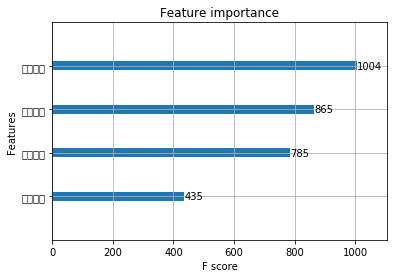

In [26]:
print(gbm.feature_importances_)
from xgboost import plot_importance
plot_importance(gbm, )
plt.show()

# 將預測結果存成CSV後上傳到kaggle

In [27]:
StackingSubmission = pd.DataFrame({ 'id': submission.id, 'type': y_pred })
StackingSubmission.to_csv("submission.csv", index=False)

In [28]:
y_pred

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3,
       3, 3, 3, 2, 3, 3, 3], dtype=int32)